# HCMUS-UNIV-WebScience-VisualizeData

## PROJECT 2: MỐI QUAN HỆ CỦA DỮ LIỆU


### I. Chuẩn bị môi trường:

In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import json
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
def fetch_value(sqlCommand):
    conn = sqlite3.connect("data.db",check_same_thread=False)
    ret = pd.read_sql_query(sqlCommand, conn)
    conn.close()
    return ret

# Query dữ liệu
def query_sql(sql:str):
    listData = fetch_value(sql)
    return listData

# Lấy bài viết theo website.
def get_bai_viet(website:str):
    return query_sql(f"select * from baiviet where website='{website}'")

class Utils:
    def convertHMtoFloat(HM):
        dv = str(HM).split(":")
        if len(dv) > 1:
            h,m = dv
        else:
            h,m = dv[0],0
        return int(h)+(float(m)/60)

### I. Tiền xử lý dữ liệu

 #### Yêu cầu: đưa các field về dạng chuẩn chung:

1. active_time: thời gian hoạt động, đưa về dạng sau:

```
    {
        <tên ngày trong tuần>:[ <thời gian mở cửa>,<thời gian đóng cửa> ]
    }

    *lowercase
    *thời gian đưa về float: 8h30 => 8.5
```
    
- ví dụ:

```
    {
        "thứ 2": [7,21.5],
        ...,
        "chủ nhật": [8,22.3]
    }
```

2. other_service: các dịch vụ khác, đưa về dạng sau:

```
    [
        <tên dịch vụ>,
        <tên dịch vụ>,
        ...,
    ]
    
    *lowercase
```
    
- ví dụ:

```
    [
        "có wifi"
        "giao hàng",
        ...,
    ]
```

#### I.1 Foody

In [ ]:
def preprocessing_Foody():
    # Code here
    data = get_bai_viet("Foody")
    active_time = data["active_time"]
    other_service = data["other_service"]
    format_time = []
    format_other = []
    for time in active_time:
        #time = time.open + ',' + time.close
        time = json.loads(time)
        time_format = []
        time_format.append(Utils.convertHMtoFloat(time['open']))
        time_format.append(Utils.convertHMtoFloat(time['close']))
        x = {
            "thứ 2":time_format,
            "thứ 3":time_format,
            "thứ 4":time_format,
            "thứ 5":time_format,
            "thứ 6":time_format,
            "thứ 7":time_format,
            "chủ nhật":time_format,
        }
        format_time.append(x)
    data['active_time'] = format_time
    for other in other_service:
        otherjs = json.loads(other)
        format_other.append([x.lower() for x in otherjs])
    data['other_service'] = format_other

    def reformat_district_map(district):
        return district.replace("huyện ","").replace("thành phố ","")
    data['district'] = data['district'].apply(reformat_district_map)

    return data

#### I.2 ShopeeFood

In [ ]:
def preprocessing_ShopeeFood():
    def maping(name):
        if name=="monday":
            return "thứ 2"
        if name=="tuesday":
            return "thứ 3"
        if name=="wednesday":
            return "thứ 4"
        if name=="thursday":
            return "thứ 5"
        if name=="friday":
            return "thứ 6"
        if name=="saturday":
            return "thứ 7"
        if name=="sunday":
            return "chủ nhật"

    def convert_active_time(HM):
        pre_format = {}
        at_js = json.loads(HM)
        atl = list(at_js)
        for key in atl:
            open,close = at_js[key].split("-")
            pre_format[maping(key)] = [Utils.convertHMtoFloat(open),Utils.convertHMtoFloat(close)]
        return pre_format

    data = get_bai_viet("ShopeeFood")
    data["active_time"] = data["active_time"].apply(convert_active_time)

    return data

#### I.3 GoogleReview

In [ ]:
def preprocessing_GoogleReview():
    def reformat_district_map(district):
        return district.replace("thành phố ","")
    
    BlackDistrict=[
        '2 hải triều',
        'vn  1 45 lý tự trọng bến nghé',
        'district 1',
        'thảo điền  2 hồ chí minh',
        'district 02',
        'phường 10  4 hồ chí minh',
        '06',
        '05',
        '19a đường 182 lã xuân oai tăng nhơn phú a',
        'số 01 đường 48 kdc bảo châu phường 16  08 tp',
        'tp',
        '30 cửu long phường 15  10  10',
        '479/55 tân thới hiệp 07',
    ]

    def maping(name):
        if name=="Thứ Hai":
            return "thứ 2"
        if name=="Thứ Ba":
            return "thứ 3"
        if name=="Thứ Tư":
            return "thứ 4"
        if name=="Thứ Năm":
            return "thứ 5"
        if name=="Thứ Sáu":
            return "thứ 6"
        if name=="Thứ Bảy":
            return "thứ 7"
        if name=="Chủ Nhật":
            return "chủ nhật"

    def convert_active_time(HM):
        pre_format = {}
        at_js = json.loads(HM)
        atl = list(at_js)
        for key in atl:
            if (key == "open"):
                pre_format = {
                    "thứ 2":[Utils.convertHMtoFloat("00:00"),Utils.convertHMtoFloat("23:59")],
                    "thứ 3":[Utils.convertHMtoFloat("00:00"),Utils.convertHMtoFloat("23:59")],
                    "thứ 4":[Utils.convertHMtoFloat("00:00"),Utils.convertHMtoFloat("23:59")],
                    "thứ 5":[Utils.convertHMtoFloat("00:00"),Utils.convertHMtoFloat("23:59")],
                    "thứ 6":[Utils.convertHMtoFloat("00:00"),Utils.convertHMtoFloat("23:59")],
                    "thứ 7":[Utils.convertHMtoFloat("00:00"),Utils.convertHMtoFloat("23:59")],
                    "chủ nhật":[Utils.convertHMtoFloat("00:00"),Utils.convertHMtoFloat("23:59")],
                    }
            if (at_js[key] == "Mở cửa cả ngày" or at_js[key] == "Đóng cửa"):
                open = "00:00"
                close = "23:59"
            else :
                time_format = at_js[key].split("–")
                open = time_format[0]
                close = time_format[len(time_format) - 1]
            
            pre_format[maping(key)] = [Utils.convertHMtoFloat(open),Utils.convertHMtoFloat(close)]
        return pre_format

    data = get_bai_viet("GoogleReview")
    data["active_time"] = data["active_time"].apply(convert_active_time)
    
    def convert_other_service(strjson):
        strjson = json.loads(strjson.replace('\\u00a0',''))
        return [x.lower() for x in strjson]
    data['other_service'] = data['other_service'].apply(convert_other_service)

    data['district'] = data['district'].apply(reformat_district_map)

    data = data[ ~(data['district'].isin(BlackDistrict)) ]

    return data

#### I.4 Tổng hợp lại dữ liệu tiền xử lý

- Thực hiện kết hợp
- Phân rã dữ liệu thành dạng phẳng

In [ ]:
def reformat(filename):
    DATA = pd.concat([preprocessing_Foody(),preprocessing_ShopeeFood(),preprocessing_GoogleReview()],ignore_index=True)

    # Chuyển complex type sang dạng giản đơn
    # active_time => thứ 2 on/off,...
    maping = {
        "thứ 2":"monday",
        "thứ 3":"tuesday",
        "thứ 4":"wednesday",
        "thứ 5":"thursday",
        "thứ 6":"friday",
        "thứ 7":"saturday",
        "chủ nhật":"sunday",
    }

    for index, row in DATA['active_time'].items():
        for weekday in maping.keys():
            open,close = None,None
            if row.get(weekday):
                open,close = row[weekday]
            DATA.loc[index,maping[weekday]+'_open'] = open
            DATA.loc[index,maping[weekday]+'_close'] = close

    # liệt kê ra toàn bộ other_service
    other_services = set()
    for _, row in DATA['other_service'].items():
        if row:
            other_services = set.union(other_services, row)
    other_services = sorted(other_services)

    for index, row in DATA['other_service'].items():
        for kw in other_services:
            value = False
            if row and kw in row:
                value = True
            DATA.loc[index,'s_'+kw] = value
    DATA.to_csv(filename,index=False)
    return DATA

In [ ]:
if os.path.exists('data_reformat.csv'):
    DATA = pd.read_csv('data_reformat.csv')
else:
    DATA = reformat('data_reformat.csv')

# Lấy ra các dịch vụ
SERVICES = []

cols = list(DATA.columns)
for col in cols:
    if col.startswith('s_'):
        SERVICES.append(col[2:])

### 2. Thống kê dữ liệu

BIẾN: 

- DATA: `dataframe` chứa toàn bộ dữ liệu
- SERVICES: `list` các dịch vụ

DANH SÁCH CÁC DỊCH VỤ:

In [ ]:
for id, v in enumerate(SERVICES):
    if id % 5 == 0:
        print()
    print(repr(v),end='\t')
print("\n\n")
print("Có tổng cộng: %d dịch vụ" % len(SERVICES))

#### Thống kê trên toàn bộ dữ liệu
- Các field: rate, rate_count, price_from, price_to

In [ ]:
#Summary statistic

DATA.describe()

#### Thống kê theo điều kiện 1

In [ ]:
# Số lượng từng website
DATA.groupby(['website'])['website'].count()

- Tiêu chí rate, rate_count, price_from, price_to

In [ ]:
colList = ['rate', 'rate_count', 'price_from', 'price_to']

In [ ]:
# Thống kê theo từng website
print(DATA[DATA['website']=='Foody'][colList].describe())
print()
print(DATA[DATA['website']=='GoogleReview'][colList].describe())
print()
print(DATA[DATA['website']=='ShopeeFood'][colList].describe())

In [ ]:
# Thống kê theo từng quận
districtList = sorted(DATA['district'].drop_duplicates().tolist())
for distr in districtList:
    print("Thống kê theo quận %s"%distr)
    print()
    print(DATA[DATA['district']==distr][colList].describe())
    print()

In [ ]:
# Thống kê theo rate
tmp = ['rate_count', 'price_from', 'price_to']

print("Thống kê những nhà hàng tốt rate > 8 sao")
print(DATA[DATA['rate']>8][tmp].describe())
print()
print("Thống kê những nhà hàng thông thường rate = 5 sao")
print(DATA[DATA['rate']==5][tmp].describe())
print()
print("Thống kê những nhà hàng tệ rate < 3 sao")
print(DATA[DATA['rate']<3][tmp].describe())

In [ ]:
# Thống kê theo ngày

print("Thống kê những nhà hàng mở cửa cả tuần")
con1 = ["monday_open", "tuesday_open", "wednesday_open", "thursday_open", "friday_open", "saturday_open", "sunday_open"]
df1=DATA
for col in con1:
    df1=df1[~df1[col].isna()]
print(df1[colList].describe())
print()

print("Thống kê những nhà hàng chỉ mở cửa từ thứ 2 tới thứ 6")
con1 = ["monday_open", "tuesday_open", "wednesday_open", "thursday_open", "friday_open"]
con2 = ["saturday_open", "sunday_open"]
df1=DATA
for col in con1:
    df1=df1[~df1[col].isna()]
for col in con2:
    df1=df1[df1[col].isna()]
print(df1[colList].describe())
print()

print("Thống kê những nhà hàng chỉ mở cửa từ thứ 7 tới chủ nhật")
con1 = ["monday_open", "tuesday_open", "wednesday_open", "thursday_open", "friday_open"]
con2 = ["saturday_open", "sunday_open"]
df1=DATA
for col in con1:
    df1=df1[df1[col].isna()]
for col in con2:
    df1=df1[~df1[col].isna()]
print(df1[colList].describe())
print()
print(DATA[~df1][colList].describe())

In [ ]:
# Thống kê theo dịch vụ

print("Thống kê những nhà hàng có từ 7 dịch vụ trở lên")
def filterbyservice(row):
    c=0
    for ser in SERVICES:
        if row["s_"+ser]:
            c+=1
            if c == 7:
                return True
    return False
df1 = DATA.apply(filterbyservice,axis=1)
print(DATA[df1][colList].describe())
print()

print("Thống kê những nhà hàng không có dịch vụ nào")
def filterbyservice(row):
    c=0
    for ser in SERVICES:
        if row["s_"+ser]:
            return False
    return True
df1 = DATA.apply(filterbyservice,axis=1)
print(DATA[df1][colList].describe())

#### Thống kê theo điều kiện 2

In [ ]:
# Code here
DATA.sort_values(by="rate", ascending=False).head()
#Những quán ăn Quận 1 mà được lượt rate cao tới thấp
DATA[DATA["district"].apply(lambda state: state[0] == "1")].sort_values(by="rate", ascending=False).head()

#Những quán có rate cao là số favorite cũng cao
columns_to_show = ["rate", "favorite", "district"]
DATA.sort_values(by="rate", ascending=False).groupby(["full_name"])[columns_to_show].describe(percentiles=[])

#Những quán có giá đắt
columns_show = ["full_name","price_from","price_to",]
DATA.sort_values(by="price_from",ascending=False).groupby(["full_name"])[columns_show].describe(percentiles=[])

###  Phần 3,4,5

#### Long section

In [ ]:
# Tiêu chí: 

#### Hiếu section

In [ ]:
# code here

#### Hằng section

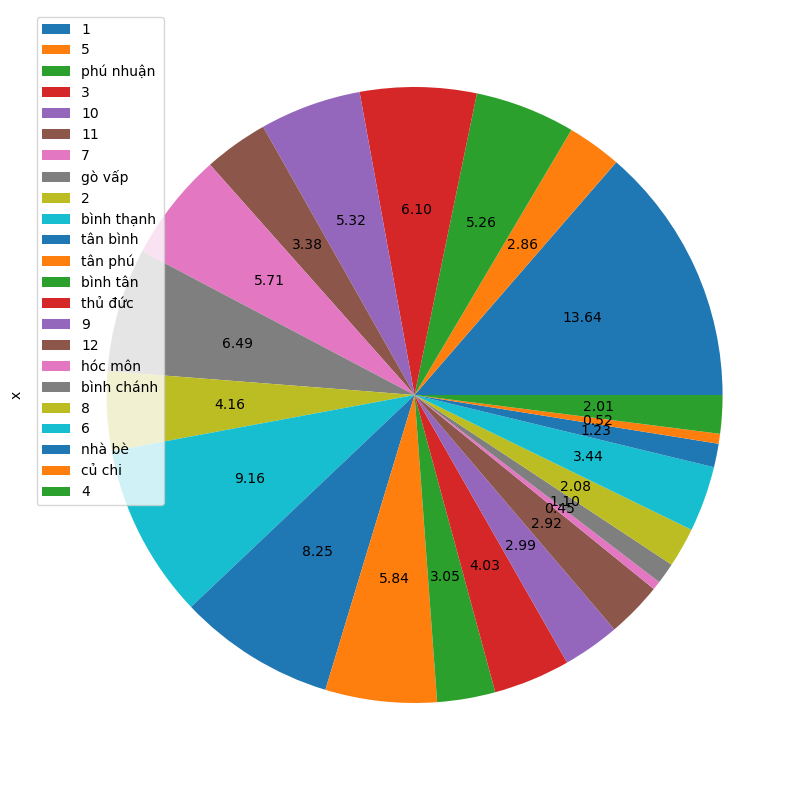

In [34]:
# code here
# Hang: Thống kê rate dưới 3* theo từng quận 
# Danh sách quận
ListDistrict = DATA["district"].drop_duplicates().tolist()
list_rate = []
count = 0
district = DATA['district'].tolist()
rate = DATA['rate'].tolist()
ListWebsite = DATA["website"].drop_duplicates().tolist()
for distr in ListDistrict:
    count = 0    
    for i in range(0,len(rate)):
        if(rate[i] <=3 and district[i]==distr):
            count = count + 1
    list_rate.append(count)
    
df = pd.DataFrame(list_rate, index= ListDistrict, columns=['x'])
 
# make the plot
#df.plot.pie(subplots=True, figsize=(8, 8), labeldistance=None)
df.plot.pie(subplots=True, figsize=(10,10), autopct='%.2f', fontsize=10, labeldistance=None);

plt.show()

In [37]:
# code here
# Hang: Thống kê hơn 10 dịch vụ theo từng quận 
# Danh sách quận
ListDistrict = DATA["district"].drop_duplicates().tolist()
active_time = []
count = 0
district = DATA['district'].tolist()
data_service = DATA['other_service'].tolist()
ListWebsite = DATA["website"].drop_duplicates().tolist()
# print(data_service)
for distr in ListDistrict:
    count = 0    
    for i in range(0,len(data_service)):
        if(data_service[i] != None and len(data_service[i]) > 10 and district[i]==distr):
            count = count + 1
    active_time.append(count)
print(active_time)
    
df = pd.DataFrame(active_time, index= ListDistrict, columns=['x'])
 
# make the plot
# df.plot.axes(subplots=True, figsize=(10,10), autopct='%.2f', fontsize=10, labeldistance=None);

# df = pd.DataFrame(dict(
#     r=active_time,
#     theta=ListDistrict))
# fig = px.line_polar(df, r='r', theta='theta', line_close=True)
# fig.show()


[22, 2, 1, 8, 1, 0, 9, 2, 2, 4, 2, 1, 1, 3, 0, 2, 0, 0, 0, 1, 1, 0, 0]


NameError: name 'px' is not defined